In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import scipy
import torch
import os

from scDisInFact import scdisinfact, create_scdisinfact_dataset

seed = 10
np.random.seed(seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
adata = sc.read_h5ad('../data/ECCITE.h5ad')
#sc.pp.filter_cells(adata, min_genes=300)
#sc.pp.filter_genes(adata, min_cells=10)
print(adata.shape)
print(adata.X[:10,:10])
print(adata)

(20729, 2000)
  (6, 1)	0.5947323441505432
  (0, 2)	0.45817938446998596
  (3, 2)	1.0809301137924194
  (4, 2)	2.1085922718048096
  (5, 2)	2.20072865486145
  (6, 2)	2.117809772491455
  (7, 2)	1.5791527032852173
  (8, 2)	2.4346671104431152
  (9, 2)	2.2123894691467285
  (9, 8)	0.7017057538032532
AnnData object with n_obs × n_vars = 20729 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase', 'n_genes'
    var: 'name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'HTO_classification_colors', 'MULTI_ID_colors', 'Phase_colors', 'gene_target_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'perturbation_colors', 'replicate_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [3]:
if isinstance(adata.X, scipy.sparse.spmatrix):
    adata.X = adata.X.toarray()

counts=adata.X
#adata.obs["batch"]=adata.obs["donor_id"].copy()

In [6]:
meta_cells=adata.obs.copy()
data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key = ['perturbation'], batch_key = 'replicate')

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


In [7]:
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [8, 4]

batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4
lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
#model.train()
result_dir="./scd/ECCITE/"
#losses = model.train_model(nepochs = nepochs, recon_loss = "NB")
#torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")
model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth", map_location = device))
_ = model.eval()

/tmp/ipykernel_2730651/419897427.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepoch

In [10]:
denoised_counts = model.predict_counts(input_counts=counts, meta_cells=meta_cells, condition_keys=['perturbation'],
                                           batch_key='replicate', predict_conds=None, predict_batch=None)

In [11]:
adata_denoised = ad.AnnData(X=denoised_counts)
adata_denoised.obs = meta_cells

/home/xx244/.conda/envs/benchmark/lib/python3.11/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 2000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


KeyError: 'Could not find key perturb01 in .var_names or .obs.columns.'

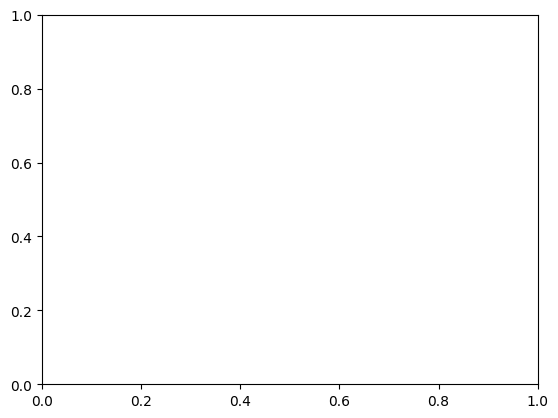

In [12]:
sc.pp.neighbors(adata_denoised)
sc.tl.umap(adata_denoised)

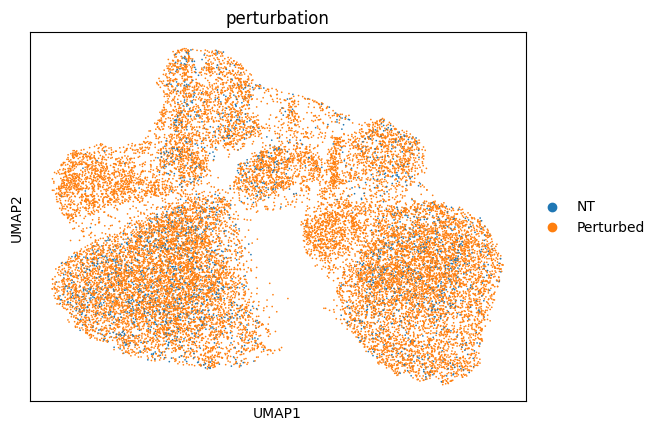

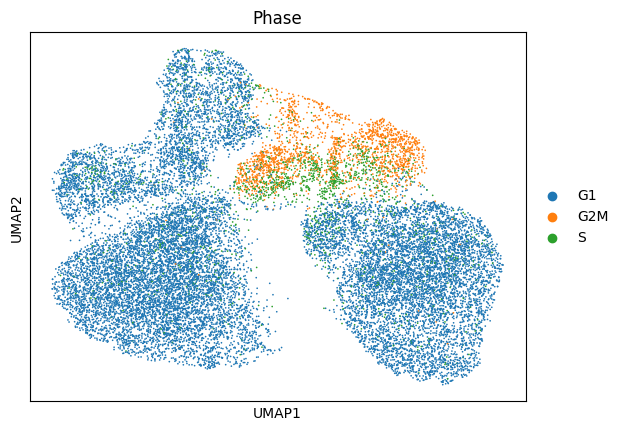

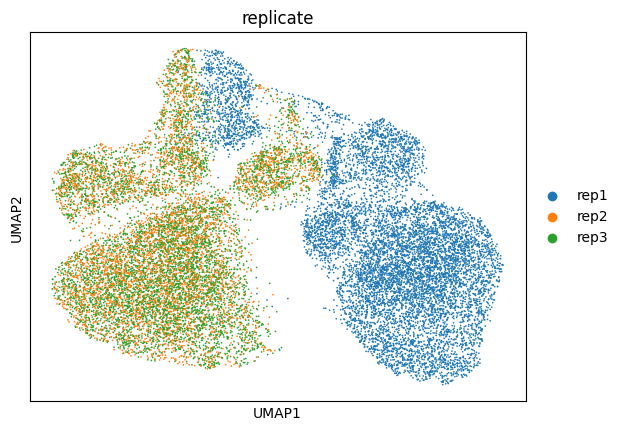

In [14]:
sc.pl.umap(adata_denoised, color="perturbation", ncols=1)
sc.pl.umap(adata_denoised, color="Phase", ncols=1)
sc.pl.umap(adata_denoised, color="replicate", ncols=1)

In [6]:
# one forward pass
z_cs = []
z_ds = []
zs = []

for dataset in data_dict["datasets"]:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = model.inference(counts = dataset.counts_norm.to(model.device), batch_ids = dataset.batch_id[:,None].to(model.device), print_stat = True)
        # pass through the decoder
        dict_gen = model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        z = torch.cat([z_c] + z_d, dim = 1)
        mu = dict_gen["mu"]    
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())
        zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis = 1))

In [7]:
latent=np.concatenate(z_cs, axis = 0)

In [8]:
meta_dict={}
for namei in meta_cells.columns.tolist():
    meta_dict[namei]=np.concatenate([x[namei].values for x in data_dict["meta_cells"]])

meta_df=pd.DataFrame(meta_dict)
meta_df

,nGene,nUMI,Cluster,Batch,CellType,Perturbation,isKey,isAnalysed,SCRUBLET,perturb01
0,4045,12747,1,10,Excitatory,Cul3,TRUE,TRUE,0.0304361468465642,mutated
1,2073,6815,2,10,Microglia,Scn2a1,TRUE,TRUE,0.0217391304347826,mutated
2,4222,14813,1,10,Excitatory,Cul3,TRUE,TRUE,0.100391134289439,mutated
3,2683,8485,2,10,Microglia,Asxl3,TRUE,TRUE,0.049553208773355,mutated
4,1945,3664,3,10,ODC,Cul3,TRUE,TRUE,0.0287110568112401,mutated
...,...,...,...,...,...,...,...,...,...,...
40598,4332,13223,8,9,Excitatory,nan,TRUE,FALSE,0.0476190476190476,nan
40599,864,1459,15,9,Inhibitory,nan,TRUE,FALSE,0.0147548786292242,nan
40600,3715,11082,26,9,Astroglia,nan,TRUE,FALSE,0.0690690690690691,nan
40601,2698,6877,7,9,Astroglia,nan,TRUE,FALSE,0.0316395014381592,nan


In [9]:
adata_latent = ad.AnnData(X=latent)
adata_latent.obs = meta_df
print(latent)

[[ 0.02448435 -0.01273245  0.09412739 ... -0.00301075  0.03981932
   0.04304856]
 [ 0.00201485  0.03802378  0.17318866 ... -0.08763638  0.05166452
   0.03347588]
 [ 0.0271406   0.0362598   0.17035979 ... -0.04158614  0.04778168
   0.00495331]
 ...
 [-0.05487204 -0.10013941  0.10300648 ... -0.02026219  0.151822
   0.07074372]
 [-0.01873049 -0.0593558   0.13741025 ... -0.06923091  0.0452796
   0.10407131]
 [-0.02002431 -0.09000535  0.10033645 ...  0.00408101  0.08799192
   0.07403151]]


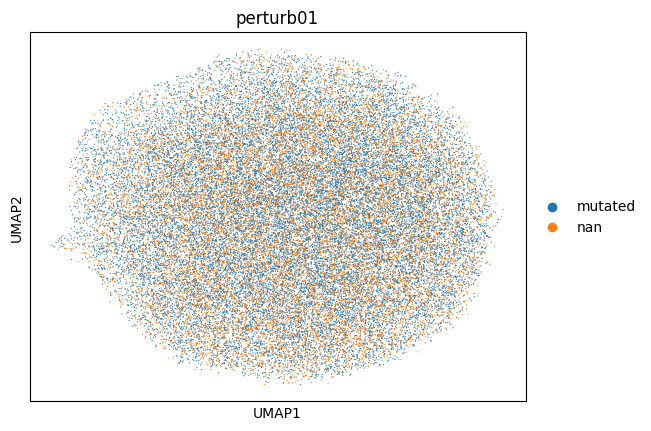

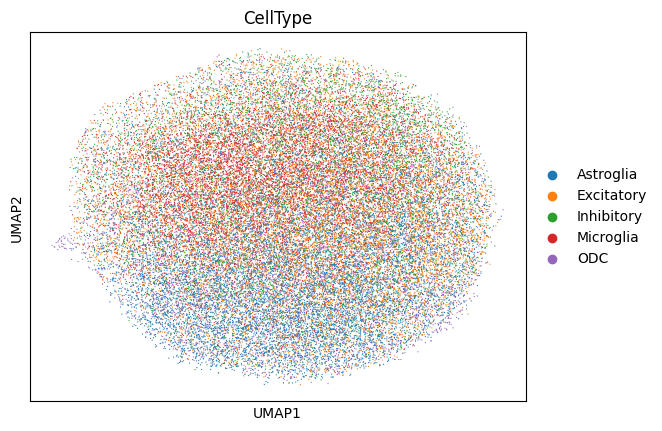

In [10]:
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color="perturb01", ncols=1)
sc.pl.umap(adata_latent, color="CellType", ncols=1)

In [11]:
len(data_dict["meta_cells"])

35

In [12]:
adata_latent=ad.AnnData(X=latent)
adata_latent.obs=meta_df